### Importing Libs

In [2]:
import datetime
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

2023-05-18 22:34:56.337965: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 22:34:56.382551: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-18 22:34:56.383373: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-18 22:34:57.274065: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Input pipeline

In [4]:
CSV_COLUMNS = [
    "weight_pounds",
    "is_male",
    "mother_age",
    "plurality",
    "gestation_weeks",
]
LABEL_COLUMN = "weight_pounds"

NUMERICAL_COLUMNS = ["mother_age", "gestation_weeks"]
CATEGORICAL_COLUMNS = ["is_male", "plurality"]

DEFAULTS = [[0.0], ["null"], [0.0], ["null"], [0.0]]

In [5]:
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label


def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = tf.data.experimental.make_csv_dataset(
        file_pattern=pattern,
        batch_size=batch_size,
        column_names=CSV_COLUMNS,
        column_defaults=DEFAULTS,
    )
    dataset = dataset.map(map_func=features_and_labels)  # features, label
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(buffer_size=1000).repeat()
    dataset = dataset.prefetch(buffer_size=1)
    return dataset

In [6]:
def create_input_layers():
    deep_inputs = {
        colname: tf.keras.layers.Input(
            name=colname, shape=(1,), dtype="float32"
        )
        for colname in NUMERICAL_COLUMNS
    }

    wide_inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(1,), dtype="string")
        for colname in CATEGORICAL_COLUMNS
    }

    inputs = {**wide_inputs, **deep_inputs}

    return inputs

### Preprocessing pipeline

In [8]:
def transform(inputs, nembeds):
    deep = {}
    wide = {}

    buckets = {
        "mother_age": np.arange(15, 45, 1).tolist(),
        "gestation_weeks": np.arange(17, 47, 1).tolist(),
    }
    bucketized = {}

    for numeric_column in NUMERICAL_COLUMNS:
        deep[numeric_column] = inputs[numeric_column]
        bucketized[numeric_column] = tf.keras.layers.Discretization(
            buckets[numeric_column]
        )(inputs[numeric_column])
        wide[f"btk_{numeric_column}"] = tf.keras.layers.CategoryEncoding(
            num_tokens=len(buckets[numeric_column]) + 1, output_mode="one_hot"
        )(bucketized[numeric_column])

    crossed = tf.keras.layers.experimental.preprocessing.HashedCrossing(
        num_bins=len(buckets["mother_age"]) * len(buckets["gestation_weeks"])
    )((bucketized["mother_age"], bucketized["gestation_weeks"]))

    deep["age_gestation_embeds"] = tf.keras.layers.Flatten()(
        tf.keras.layers.Embedding(
            input_dim=len(buckets["mother_age"])
            * len(buckets["gestation_weeks"]),
            output_dim=nembeds,
        )(crossed)
    )

    vocab = {
        "is_male": ["True", "False", "Unknown"],
        "plurality": [
            "Single(1)",
            "Twins(2)",
            "Triplets(3)",
            "Quadruplets(4)",
            "Quintuplets(5)",
            "Multiple(2+)",
        ],
    }

    for categorical_column in CATEGORICAL_COLUMNS:
        wide[categorical_column] = tf.keras.layers.StringLookup(
            vocabulary=vocab[categorical_column], output_mode="one_hot"
        )(inputs[categorical_column])

    return wide, deep

### Model and output layer

In [10]:
def get_model_outputs(wide_inputs, deep_inputs, dnn_hidden_units):
    layers = [int(x) for x in dnn_hidden_units]
    deep = deep_inputs
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(
            units=numnodes, activation="relu", name=f"dnn_{layerno + 1}"
        )(deep)

    deep_out = deep
    
    wide_out = tf.keras.layers.Dense(
        units=10, activation="relu", name="linear"
    )(wide_inputs)

    both = tf.keras.layers.Concatenate(name="both")([deep_out, wide_out])

    output = tf.keras.layers.Dense(units=1, activation="linear", name="weight")(both)

    return output

### Custom eval metric

In [12]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean((y_pred - y_true) ** 2))

### Training pipeline

In [15]:
def build_wide_deep_model(dnn_hidden_units=[64, 32], nembeds=3):
    inputs = create_input_layers()

    wide, deep = transform(inputs, nembeds)

    wide_inputs = tf.keras.layers.Concatenate()(wide.values())
    deep_inputs = tf.keras.layers.Concatenate()(deep.values())

    output = get_model_outputs(wide_inputs, deep_inputs, dnn_hidden_units)

    model = tf.keras.models.Model(inputs=inputs, outputs=output)
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])

    return model

print("Here is our wide and deep architecture so far:\n")
model = build_wide_deep_model()
print(model.summary())

Here is our wide and deep architecture so far:

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mother_age (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 gestation_weeks (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 discretization_2 (Discretizati  (None, 1)           0           ['mother_age[0][0]']             
 on)                                                                                              
                                                                                                  
 discretization_3 (Discretizati  (None, 1)  

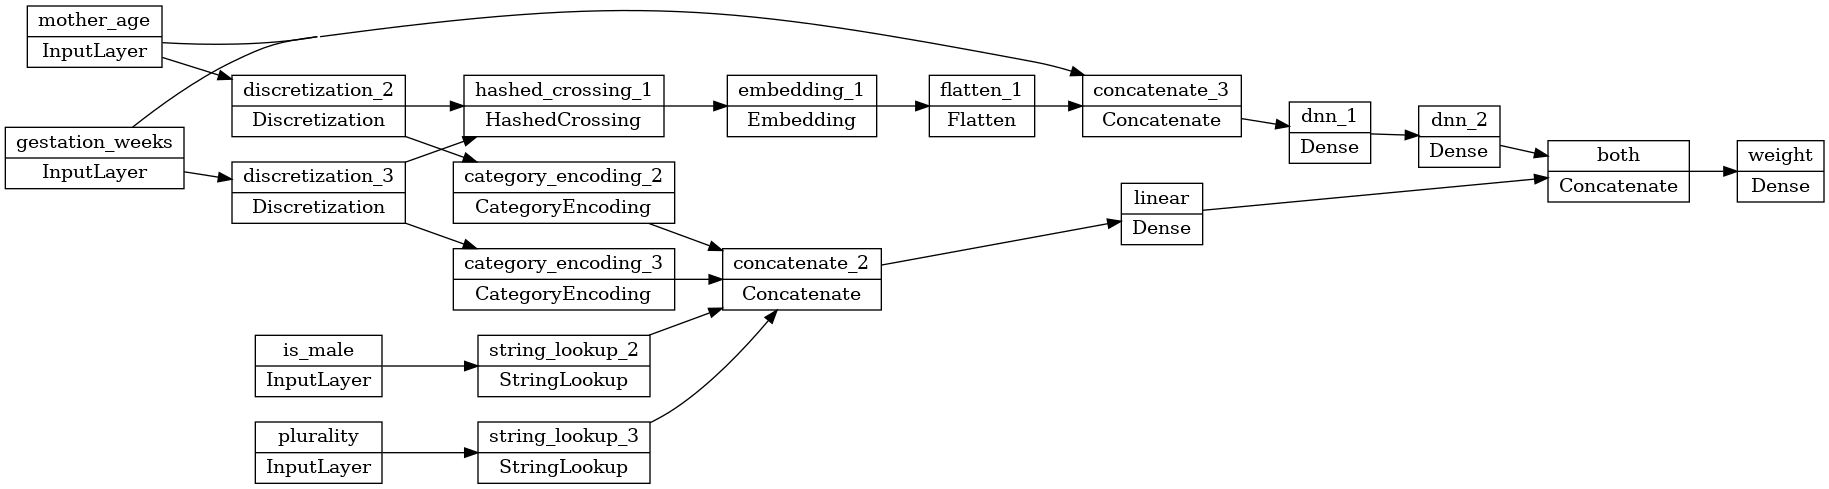

In [16]:
tf.keras.utils.plot_model(
    model=model, to_file="wd_model.png", show_shapes=False, rankdir="LR"
)

In [18]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5
NUM_EVALS = 5
NUM_EVAL_EXAMPLES = 10000

trainds = load_dataset(
    pattern="../datasets/baby-train*",
    batch_size=TRAIN_BATCH_SIZE,
    mode=tf.estimator.ModeKeys.TRAIN,
)

evalds = load_dataset(
    pattern="../datasets/baby-eval*", batch_size=1000, mode=tf.estimator.ModeKeys.EVAL
).take(count=NUM_EVAL_EXAMPLES // 1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=logdir, histogram_freq=1
)

history = model.fit(
    trainds,
    validation_data=evalds,
    epochs=NUM_EVALS,
    steps_per_epoch=steps_per_epoch,
    callbacks=[tensorboard_callback],
)

Epoch 1/5


2023-05-18 22:38:35.225185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-18 22:38:35.225518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


312/312 [==============================] - ETA: 0s - loss: 1.6247 - rmse: 1.1922 - mse: 1.6247

2023-05-18 22:38:38.665644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]
2023-05-18 22:38:38.666021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [1]
	 [[{{node Placeholder/_0}}]]


312/312 [==============================] - 5s 6ms/step - loss: 1.6247 - rmse: 1.1922 - mse: 1.6247 - val_loss: 1.2110 - val_rmse: 1.1004 - val_mse: 1.2110
Epoch 2/5
312/312 [==============================] - 2s 7ms/step - loss: 1.1675 - rmse: 1.0681 - mse: 1.1675 - val_loss: 1.1530 - val_rmse: 1.0737 - val_mse: 1.1530
Epoch 3/5
312/312 [==============================] - 1s 5ms/step - loss: 1.1416 - rmse: 1.0577 - mse: 1.1416 - val_loss: 1.1127 - val_rmse: 1.0545 - val_mse: 1.1127
Epoch 4/5
312/312 [==============================] - 2s 5ms/step - loss: 1.1308 - rmse: 1.0531 - mse: 1.1308 - val_loss: 1.1769 - val_rmse: 1.0846 - val_mse: 1.1769
Epoch 5/5
312/312 [==============================] - 1s 4ms/step - loss: 1.0876 - rmse: 1.0324 - mse: 1.0876 - val_loss: 1.0903 - val_rmse: 1.0438 - val_mse: 1.0903


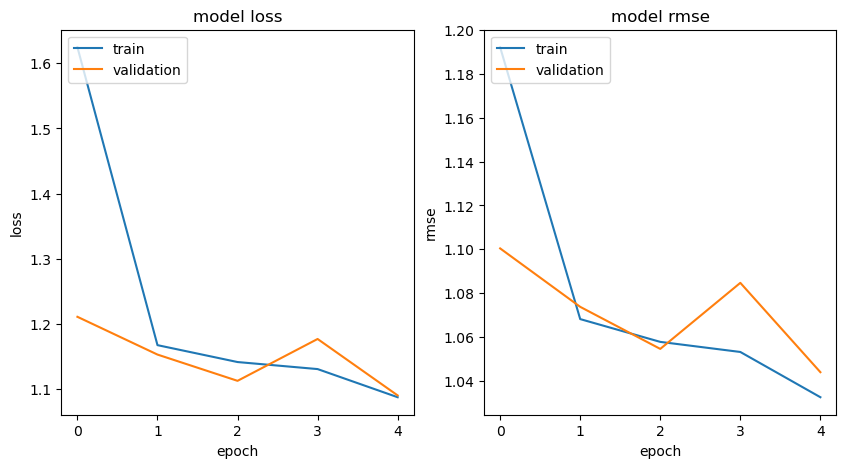

In [19]:
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(["loss", "rmse"]):
    ax = fig.add_subplot(nrows, ncols, idx + 1)
    plt.plot(history.history[key])
    plt.plot(history.history[f"val_{key}"])
    plt.title(f"model {key}")
    plt.ylabel(key)
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left");

In [20]:
OUTPUT_DIR = "babyweight_trained_wd"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(
    OUTPUT_DIR, datetime.datetime.now().strftime("%Y%m%d%H%M%S")
)
tf.saved_model.save(
    obj=model, export_dir=EXPORT_PATH
)
print(f"Exported trained model to {EXPORT_PATH}")

2023-05-18 22:38:50.920683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gestation_weeks' with dtype float and shape [?,1]
	 [[{{node gestation_weeks}}]]
2023-05-18 22:38:50.920839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'mother_age' with dtype float and shape [?,1]
	 [[{{node mother_age}}]]
2023-05-18 22:38:50.999220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gestation_weeks' with dtype float and shape [?,1]
	 [[{{nod

INFO:tensorflow:Assets written to: babyweight_trained_wd/20230518223850/assets


INFO:tensorflow:Assets written to: babyweight_trained_wd/20230518223850/assets


Exported trained model to babyweight_trained_wd/20230518223850
